# DCGAN with cats dataset

## import nesessary modules 

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

from torch.utils.tensorboard import SummaryWriter
from modules.dcgan import Discriminator, Generator, initialize_weights

## set agnostic

In [20]:
# agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## load data set

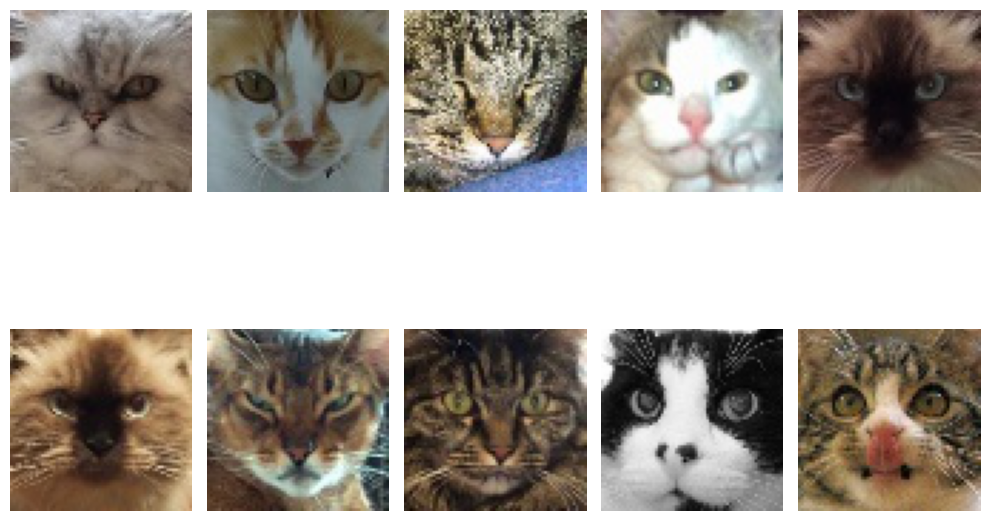

In [2]:

# Set the path to the dataset
dataset_path = 'dataset/cats/'

# Get the list of image filenames
image_filenames = os.listdir(dataset_path)

# Set the number of images to plot
num_images = 10

# Create a new figure with multiple subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 8))

# Iterate over the first num_images filenames and plot the corresponding images
for i, filename in enumerate(image_filenames[:num_images]):
    # Load the image
    img_path = os.path.join(dataset_path, filename)
    img = Image.open(img_path)

    # Convert the image to a numpy array
    img_arr = np.asarray(img)

    # Plot the image on the corresponding subplot
    row = i // 5
    col = i % 5
    axes[row, col].imshow(img_arr, cmap='gray')
    axes[row, col].axis('off')

# Adjust the spacing of the figure
fig.tight_layout()

# Show the figure
plt.show()


## load images to tensor and normalize images

In [3]:
# set image size
img_size = 64

# Set the path to the dataset
dataset_path = 'dataset/cats/'

# Set the number of images to transform
num_images = 15747

In [4]:
# Get the list of image filenames
image_filenames = os.listdir(dataset_path)

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # convert PIL image to tensor and scales data into [0,1] 
    # transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # Scale between [-1, 1] by (input[channel] - mean[channel]) / std[channel]
])

# Create a list to store the transformed images
transformed_images = []

# Iterate over the first num_images filenames and transform the corresponding images
for i, filename in enumerate(image_filenames[:num_images]):
    # Load the image
    img_path = os.path.join(dataset_path, filename)
    image = Image.open(img_path)

    # Apply the transformations
    transformed_image = transform(image)

    # Append the transformed image to the list
    transformed_images.append(transformed_image)

# Convert the list of transformed images to a PyTorch tensor
transformed_images = torch.stack(transformed_images)

print(f'Loaded data: {transformed_images.shape}')

Loaded data: torch.Size([15747, 3, 64, 64])


## separate batch size 

In [5]:
# set batch size
batch_size = 16

data_loader = DataLoader(transformed_images, batch_size=batch_size, shuffle=True, drop_last=True)

data_iter = iter(data_loader)
print(next(data_iter).shape)

torch.Size([16, 3, 64, 64])


## import the model

In [22]:
from modules.dcgan import Discriminator, Generator, initialize_weights

## Set hyperparameter before training iteration

In [21]:
# base on the paper
LEARNING_RATE = 2e-4  
BATCH_SIZE = 16
IMAGE_SIZE = 64
CHANNELS_IMG = 3
LATENT_DIM = 100

NUM_EPOCHS = 200

FEATURES_DISC = 64
FEATURES_GEN = 64

## Train model and save weight and log 

### define save weight function

In [8]:
def save_weight(model, epoch, out_path="weight/DCGAN/cats/",prefix=""):
    """Save weight to xxx.pt file"""
    os.makedirs(out_path, exist_ok=True)
    torch.save(model.state_dict(), f'{out_path}{prefix}{epoch}.pt')

### define gen_log function

In [34]:
import subprocess

def gen_log(log_path, message):
    command = ["python", "./modules/gen_log.py", "--log_file", log_path, "--message", message]

    subprocess.run(command, check=True)

In [10]:
gen = Generator(LATENT_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

# init weight
initialize_weights(gen)
initialize_weights(disc)

## training process
parameter base on DCGAN paper https://arxiv.org/abs/1511.06434

In [11]:
import time
import numpy as np

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, LATENT_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):

    # Shuffle the dataset at the beginning of each epoch
    data_loader.shuffle()


    lossG = []
    lossD = []

    # use time for time measurement
    start_time = time.time()
    
    for batch_idx, real in enumerate(data_loader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # append loss to list
        lossG.append(loss_gen)
        lossD.append(loss_disc)

        # # Print losses occasionally and print to tensorboard
        if batch_idx % BATCH_SIZE == 0:
            step += 1

    end_time = time.time()
    epoch_time = end_time - start_time

    meanG_loss = lossG / batch_size
    meanD_loss = lossD / batch_size

    message = f'''Epoch: {epoch+1}, Using Time: {epoch_time:.4f}, Loss D: {meanD_loss:.4f}, loss G: {meanG_loss:.4f}'''

    # generate log
    gen_log("./logs/cats/DCGAN.log", message)

    # save weight of models
    save_weight(gen, epoch+1, out_path="weight/DCGAN/cats/", prefix="G")
    save_weight(disc, epoch+1, out_path="weight/DCGAN/cats/", prefix="D")

    print(
        f"Epoch [{epoch+1}/{NUM_EPOCHS}] Batch {batch_idx+1}/{len(data_loader)} Using Time: {epoch_time:.4f}\
            Loss D: {meanD_loss:.4f}, loss G: {meanG_loss:.4f}"
    )

    with torch.no_grad():
        fake = gen(fixed_noise)
        # take out (up to) 32 examples
        img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

        writer_real.add_image("Real", img_grid_real, global_step=step)
        writer_fake.add_image("Fake", img_grid_fake, global_step=step)


2023-06-01 08:05:31.888163: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 08:05:51.317868: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2023-06-01 08:05:51.328332: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2023-06-01 08:05:51.328358: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

Epoch [1/200] Batch 984/984 Using Time: 143.0747            Loss D: 0.6648, loss G: 1.4888
Epoch [2/200] Batch 984/984 Using Time: 131.8725            Loss D: 0.6974, loss G: 1.8257
Epoch [3/200] Batch 984/984 Using Time: 132.2814            Loss D: 0.4912, loss G: 2.1599
Epoch [4/200] Batch 984/984 Using Time: 132.6716            Loss D: 0.3327, loss G: 3.0029
Epoch [5/200] Batch 984/984 Using Time: 132.7929            Loss D: 0.3175, loss G: 2.6841
Epoch [6/200] Batch 984/984 Using Time: 132.9167            Loss D: 0.2562, loss G: 3.8833
Epoch [7/200] Batch 984/984 Using Time: 133.1608            Loss D: 0.3846, loss G: 3.5697
Epoch [8/200] Batch 984/984 Using Time: 133.1185            Loss D: 0.1566, loss G: 3.4150
Epoch [9/200] Batch 984/984 Using Time: 133.3213            Loss D: 0.1036, loss G: 3.7678
Epoch [10/200] Batch 984/984 Using Time: 133.7352            Loss D: 0.2773, loss G: 4.0577
Epoch [11/200] Batch 984/984 Using Time: 133.6458            Loss D: 0.1972, loss G: 4.49

# Measure FID

You need to import model first
and masure define gen_log function

## define FID measurement function 

In [50]:
import subprocess
import torch
from torchvision.utils import save_image
import re

# Create a function to run the FID script
def run_fid(real_path, gen_path, epoch):
    command = ["python", "-m", "pytorch_fid", real_path, gen_path]

    output = subprocess.run(command, capture_output=True, text=True)

    # Extract the FID score using regular expressions
    output = output.stdout
    fid_score_match = re.search(r"FID:\s+(\d+\.\d+)", output)
    
    if fid_score_match:
        fid_score = float(fid_score_match.group(1))
        print("FID score:", fid_score)

        # Write the FID score to the log file
        gen_log(log_path="logs/fid/DCGAN.log", message=f"Epoch: {epoch}, FID score: {fid_score}")
        
    else:
        print("FID score not found in the output.")

def FID_measure(model, sample_size=100*8, batch_size=8, device="cpu", real_path="dataset/cats/", gen_path="generated_images", epoch=int):
    # Set the model to evaluation mode
    model.eval()

    # Create a folder for generated images if it doesn't exist
    os.makedirs(gen_path, exist_ok=True)
    torch.manual_seed(2023)

    # Generate images
    with torch.no_grad():
        for i in range(0, sample_size, batch_size):
            
            # Random value from the normal distribution
            z = torch.randn(batch_size, LATENT_DIM, 1, 1).to(device)

            # Random from uniform distribution in range [-2, 2]
            # z = torch.FloatTensor(batch_size, LATENT_DIM, 1, 1).uniform_(-2, 2).to(device)

            # Generate images
            gen_imgs = model(z)

            # Save images
            for j in range(batch_size):
                save_image(gen_imgs[j], f"{gen_path}/{i+j}.png", normalize=True)
        
    # Measure FID score between the real and generated images
    run_fid(real_path, gen_path, epoch)


## Load weight of model to measure FID score

In [51]:
def load_weight( generator, discriminator=None, weight_path="", index=int):
    # Load the saved weights
    generator.load_state_dict(torch.load(f'{weight_path}/G{index}.pt'))
    # discriminator.load_state_dict(torch.load(f'{weight_path}/D{index}.pt'))

    pass
    

In [52]:
import glob
from pathlib import Path

# Specify the directory path
directory_path = Path('weight/DCGAN/cats/')

# Get the list of files ending with ".pth"
# file_list = list(directory_path.glob('*.pt'))


gen = Generator(LATENT_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
# disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

for i in range(NUM_EPOCHS):
    index_weight = i+1

    load_weight(generator=gen, weight_path=directory_path, index=index_weight)

    FID_measure(gen, sample_size=10000, batch_size=16, device=f"{device}", gen_path=f"gen_image/DCGAN/cats/{index_weight}/", epoch=index_weight)   



FID score: 270.6328301679047
FID score: 226.82745403139955
FID score: 172.63450881216625
FID score: 120.60184483261585
FID score: 151.5434287923158
FID score: 98.62397011516231
FID score: 83.27025993524609
FID score: 62.43305123120976
FID score: 57.052163923021965
FID score: 43.78379678172382
FID score: 56.18988437757801
FID score: 52.44454798720494
FID score: 70.20498440348229
FID score: 39.96132919881208
FID score: 48.67617575546518
FID score: 34.89332559128326
FID score: 32.91685299537647
FID score: 29.465070912635326
FID score: 33.57157960108347
FID score: 25.479917204863426
FID score: 24.92191525097988
FID score: 26.339073927992956
FID score: 24.171065075136084
FID score: 23.956106362542698
FID score: 22.74347382281738
FID score: 27.874758545204088
FID score: 25.465895419900676
FID score: 23.98922685790032
FID score: 26.143904273294623
FID score: 21.123253783833974
FID score: 21.37103540531217
FID score: 26.486400583493236
FID score: 19.031842069813138
FID score: 23.95205826781500

## Plot Graph

import matplotlib.pyplot as plt

log_file = 'logs/fid/DCGAN.log'  # Replace with the path to your log file

# Read the log file
with open(log_file, 'r') as file:
    lines = file.readlines()

# Initialize lists to store the epoch and FID score data
epochs = []
fid_scores = []

# Process each log entry
for line in lines:
    parts = line.split(':')  # Split the line at the ":" character
    if len(parts) == 3:  # Ensure it is a valid log entry with three parts
        epoch = int(parts[1].strip())
        fid_score = float(parts[2].strip())
        epochs.append(epoch)
        fid_scores.append(fid_score)

# Plot the graph
plt.plot(epochs, fid_scores)
plt.xlabel('Epoch')
plt.ylabel('FID Score')
plt.title('FID Score per Epoch')
plt.grid(True)
plt.show()
